In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.conversion import localconverter
base = importr('base')
deseq = importr('DESeq2')
import gseapy as gp
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Read counts values for DESeq2 tests
pdf = pd.read_csv('../../masked/patients_info.csv', index_col=0)
counts = pd.read_csv('../../masked/gene_counts.csv', index_col=0).T
counts.index = [i.split('.')[0] for i in counts.index]
counts.index = counts.index.map(pd.read_table('https://github.com/cclab-brca/neoadjuvant-therapy-response-predictor\
/raw/master/resources/EnsemblID.to.Hugo.v87.tsv.gz', index_col=0)['Hugo'])
counts = counts.loc[(~counts.index.isna())&(~counts.index.duplicated())].T
counts = counts.loc[:,(counts==0).mean()<0.1]
counts = pd.merge(pdf[['Response','Molecular_Subtype']], counts, left_index=True, right_index=True)

# TPM values for Ranksums tests
tpm = pd.read_csv('../../masked/TPM.csv', index_col=0)
tpm = pd.merge(pdf[['Response','Molecular_Subtype']], tpm, left_index=True, right_index=True, how='inner')

In [3]:
deres = {}

for i in pdf['Molecular_Subtype'].unique():
    counts_t = counts[counts['Molecular_Subtype']==i].sort_values('Response')
    
    tmp_t_ctr = tpm.loc[(tpm['Molecular_Subtype']==i)&(tpm['Response']==1)]
    tmp_t_case = tpm.loc[(tpm['Molecular_Subtype']==i)&(tpm['Response']==0)]

    with localconverter(ro.default_converter + pandas2ri.converter):
        count_matrix = ro.conversion.py2rpy(counts_t.drop(columns=['Response','Molecular_Subtype']).T)

    with localconverter(ro.default_converter + pandas2ri.converter):
        design_matrix = ro.conversion.py2rpy(counts_t[['Response']])

    dds = deseq.DESeqDataSetFromMatrix(countData=count_matrix, 
                                            colData=design_matrix,
                                            design=Formula("~Response"))
    dds = deseq.DESeq(dds)

    with localconverter(ro.default_converter + pandas2ri.converter):
        pd_from_r_df = ro.conversion.rpy2py(base.as_data_frame(deseq.results(dds)))
        
    ranksum_pdict = {}
    for j in tmp_t_ctr.columns:
        ranksum_pdict[j] = st.ranksums(tmp_t_ctr[j],tmp_t_case[j]).pvalue

    deres[i] = pd_from_r_df.sort_values('padj')
    deres[i]['prank'] = deres[i].index.map(ranksum_pdict)
    deres[i].to_csv('./DEGs_'+i+'.csv')

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 570 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for hig

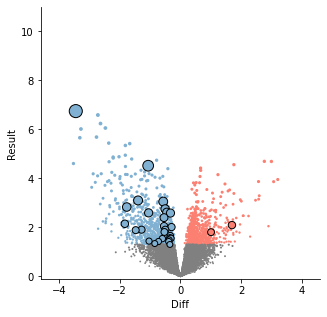

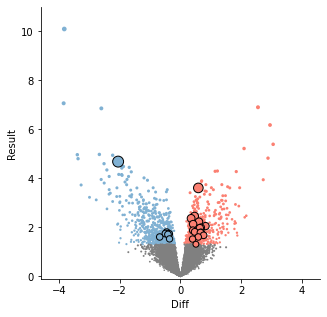

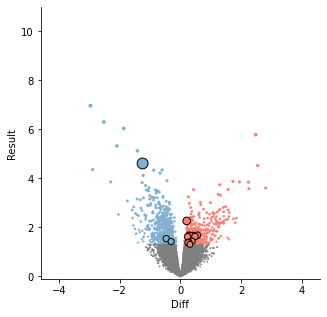

In [4]:
res_de = {}
res_gs = {}

# Volcano plots and GSEA analysis
for i in pdf['Molecular_Subtype'].unique():
    sig_c1 = deres[i].dropna()[[]]
    sig_c1['Diff'] = deres[i].dropna()['log2FoldChange'] # fold change from DESeq2
    sig_c1['Result'] = deres[i].dropna()['pvalue'] # p value from DESeq2
    sig_c1['prank'] = deres[i].dropna()['prank'] # p value from ranksums
    sig_c1['GENE'] = deres[i].dropna().index

    def color(df):    
        return 1*(df['Result']<0.05)*(df['Diff']>0.0) - 1*(df['Result']<0.05)*(df['Diff']<-0.0) 

    # Highlight breast cancer drivers
    BRCA_related = sorted(set(list(pd.read_csv('./BRCA_related.genes.csv')['core_genes'])+\
               list(pd.read_csv('./BRCA_related.genes.csv')['extended_genes'])))
    def check_related(x):
        return x in BRCA_related

    plt.subplots(figsize=[5,5])

    sns.scatterplot(sig_c1['Diff'],\
                    -1*sig_c1['Result'].apply(np.log10),\
                    c=sig_c1.apply(color, axis=1).map({0:'grey',-1:sns.color_palette("Set3")[4],1:sns.color_palette("Set3")[3],}),linewidth=0,\
                   s=2-2*sig_c1['Result'].apply(np.log10))

    sns.scatterplot(sig_c1.loc[(sig_c1['GENE'].apply(check_related))&\
                               (sig_c1.apply(color, axis=1)!=0)&\
                               (sig_c1['prank']<0.05)]['Diff'],\
                    -1*sig_c1.loc[(sig_c1['GENE'].apply(check_related))&\
                               (sig_c1.apply(color, axis=1)!=0)&\
                               (sig_c1['prank']<0.05)]['Result'].apply(np.log10),\
                    color=sig_c1.loc[(sig_c1['GENE'].apply(check_related))&\
                               (sig_c1.apply(color, axis=1)!=0)&\
                               (sig_c1['prank']<0.05)].apply(color, axis=1).map({0:'grey',-1:sns.color_palette("Set3")[4],1:sns.color_palette("Set3")[3],}),\
                    linewidth=1,edgecolor='black',\
                    s=2-25*sig_c1.loc[(sig_c1['GENE'].apply(check_related))&\
                               (sig_c1.apply(color, axis=1)!=0)&\
                               (sig_c1['prank']<0.05)]['Result'].apply(np.log10))
    sns.despine(left=False, bottom=False, right=True, top=True)

    plt.xlim([-4.6,4.6])
    plt.ylim([-0.1,11])
    plt.yticks([0,2,4,6,8,10])
    plt.savefig('volcano_'+i+'.pdf')
    
    res_de[i] = sig_c1
    
    # Run GSEA prerank (rank by fold change)

    gene_sets="/Users/zzhuay/GSEA_4.1.0/ref/msigdb.hallmark.gmt"

    pre_res = gp.prerank(rnk=sig_c1[sig_c1['Result']<0.05][['Diff']], gene_sets=gene_sets,\
                         min_size=0,max_size=201,seed=1,
                         outdir='./prerank_'+str(i), format='pdf')
    res_gs[i] = pre_res.res2d.sort_values('nes')
    res_gs[i].to_csv('GSEA_'+i+'.csv')